# This is just a notebook to visualise 1kHz filtered raw data

## Setup everything

### Import packages

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from ephyviewer import mkQApp, MainViewer, TraceViewer, TimeFreqViewer, InMemoryAnalogSignalSource, EventList
from ephyviewer import AnalogSignalSourceWithScatter, SpikeInterfaceRecordingSource, InMemoryEventSource

import mbTools

## Choose experiment
Select the folder of the experiment to display. If the experiment was already analyzed, you can select the iterimAnalysis folder. Otherwise select the raw data recording folder.

In [2]:
theExpe = mbTools.experiment()

Local config file loaded from localConfig.ini
current folder \\10.69.168.1\crnldata\waking\audrey_hay\NPX\interimAnalysis\NPX1\Reuniens\Expe_2024-07-20_12-45-29 contains a config file


FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\NPX\interimAnalysis\NPX1\Reuniens\Expe_2024-07-20_1…

## Load Data

### Map the whole data into memory

In [3]:
theExpe.analyseExpe_findData(fullSampling=False)
#theExpe.setnum_lfp_channels(32)

Mapping found and loaded
{'EMG': [{'canal': '6', 'status': 1}], 'PFC': [{'canal': '21', 'status': 2}, {'canal': '20', 'status': 1}], 'OFC': [{'canal': '19', 'status': 2}, {'canal': '18', 'status': 1}], 'M2': [{'canal': '27', 'status': 2}, {'canal': '26', 'status': 1}], 'M1 -> DOWN States': [{'canal': '16', 'status': 2}, {'canal': '17', 'status': 1}], 'S1fl': [{'canal': '29', 'status': 2}, {'canal': '28', 'status': 1}], 'RSP': [{'canal': '30', 'status': 2}, {'canal': '31', 'status': 1}], 'CA1-1': [{'canal': '1', 'status': 2}, {'canal': '0', 'status': 1}], 'V1': [{'canal': '11', 'status': 2}, {'canal': '10', 'status': 1}], 'CA1-2': [{'canal': '2', 'status': 2}, {'canal': '3', 'status': 1}], 'S1bf': [{'canal': '14', 'status': 2}, {'canal': '15', 'status': 1}], 'mEC': [{'canal': '13', 'status': 2}, {'canal': '12', 'status': 1}]}
********found some .bin files********
data recorded with Bonsai
importing \\10.69.168.1\crnldata\waking\audrey_hay\NPX\NPX1\Reuniens\Expe_2024-07-20_12-45-29\OE_32

c:\Users\manip\Documents\MB\HayLabAnalysis\.venv\Lib\site-packages\spikeinterface\core\baserecording.py:488: UserWarning: Setting times with Recording.set_times() is not recommended because times are not always propagated across preprocessingUse this carefully!
  warnings.warn(


### Extract submatrix of interest

In [4]:
#initiate combined and channelLabels
combined =  {}
channelLabels = {}
sample_rates = {}
t_start = {}

In [5]:
#LFP
if 'OE_LFP' in theExpe.data:
    sample_rates['LFP'] = theExpe.data['OE_LFP'].sampling_rate #20000
    t_start['LFP'] = theExpe.data['OE_LFP'].start
    combined['LFP'] = theExpe.data['OE_LFP'].combineStructures("All")#['M1'])
    channelLabels['LFP'] = theExpe.data['OE_LFP'].channelLabels[:]
    print("LFP data combined")
else:
    print("no LFP data to combine")

dict_keys(['EMG', 'PFC', 'OFC', 'M2', 'M1 -> DOWN States', 'S1fl', 'RSP', 'CA1-1', 'V1', 'CA1-2', 'S1bf', 'mEC'])
EMG -> [{'canal': '6', 'status': 1}]
Getting floating signal of channel 6 for EMG
PFC -> [{'canal': '21', 'status': 2}, {'canal': '20', 'status': 1}]
Getting differential signal of channel 21 - channel 20 for PFC
OFC -> [{'canal': '19', 'status': 2}, {'canal': '18', 'status': 1}]
Getting differential signal of channel 19 - channel 18 for OFC
M2 -> [{'canal': '27', 'status': 2}, {'canal': '26', 'status': 1}]
Getting differential signal of channel 27 - channel 26 for M2
M1 -> DOWN States -> [{'canal': '16', 'status': 2}, {'canal': '17', 'status': 1}]
Getting differential signal of channel 16 - channel 17 for M1 -> DOWN States
S1fl -> [{'canal': '29', 'status': 2}, {'canal': '28', 'status': 1}]
Getting differential signal of channel 29 - channel 28 for S1fl
RSP -> [{'canal': '30', 'status': 2}, {'canal': '31', 'status': 1}]
Getting differential signal of channel 30 - channel 3

In [6]:
#LFP
if 'LFP_DS' in theExpe.data:
    theExpe.data['LFP_DS'].sampling_rate=1000
    theExpe.data['LFP_DS'].start=0
    print(theExpe.data['LFP_DS'].sampling_rate)

    sample_rates['LFP_DS'] = theExpe.data['LFP_DS'].sampling_rate #20000
    t_start['LFP_DS'] = theExpe.data['LFP_DS'].start
    combined['LFP_DS'] = theExpe.data['LFP_DS'].combineStructures("All")#['M1'])
    channelLabels['LFP_DS'] = theExpe.data['LFP_DS'].channelLabels[:]
    print("LFP data combined")
else:
    print("no LFP data to combine")

no LFP data to combine


In [7]:
#NPX
if 'NPX' in theExpe.data:
    sample_rates['NPX'] = theExpe.data['NPX'].sampling_rate #30000
    t_start['NPX'] = theExpe.data['NPX'].start
    combined['NPX'] = theExpe.data['NPX'].signal['spike']
    channelLabels['NPX'] = theExpe.data['NPX'].channelLabels
    print("NPX data combined")
else:
    print("no NPX data to combine")

NPX data combined


In [8]:
if 'Spindles' in theExpe.data:
    structure = 'M1'
    All_Spindle = theExpe.data['Spindles'][structure]
    print(All_Spindle)

1526.9000135063286
29578033
dict_keys(['EMG', 'PFC', 'OFC', 'M2', 'M1 -> DOWN States', 'S1fl', 'RSP', 'CA1-1', 'V1', 'CA1-2', 'S1bf', 'mEC'])
EMG -> [{'canal': '6', 'status': 1}]
Getting floating signal of channel 6 for EMG
PFC -> [{'canal': '21', 'status': 2}, {'canal': '20', 'status': 1}]
Getting differential signal of channel 21 - channel 20 for PFC
OFC -> [{'canal': '19', 'status': 2}, {'canal': '18', 'status': 1}]
Getting differential signal of channel 19 - channel 18 for OFC
M2 -> [{'canal': '27', 'status': 2}, {'canal': '26', 'status': 1}]
Getting differential signal of channel 27 - channel 26 for M2
M1 -> DOWN States -> [{'canal': '16', 'status': 2}, {'canal': '17', 'status': 1}]
Getting differential signal of channel 16 - channel 17 for M1 -> DOWN States
S1fl -> [{'canal': '29', 'status': 2}, {'canal': '28', 'status': 1}]
Getting differential signal of channel 29 - channel 28 for S1fl
RSP -> [{'canal': '30', 'status': 2}, {'canal': '31', 'status': 1}]
Getting differential sign

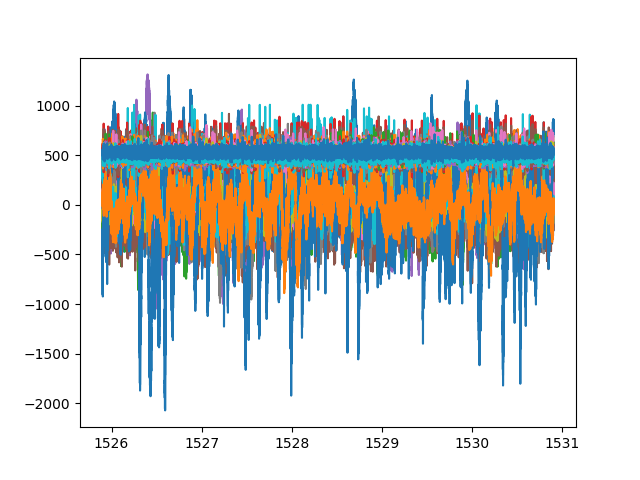

TypeError: sequence item 0: expected str instance, WindowsPath found

In [ ]:
#this cell can be used to plot very precisely time of interest. Beware that it conflicts with ephyviewer however. It might be possible to have 2 notebooks open simultanéeously...
if True:
    %matplotlib widget
    #you can confiure a y-offset and some scaling, have a look at the help of superCleanPlot
    mbTools.tools.superCleanPlot(theExpe.data['OE_LFP'], theExpe.data['NPX'], structureLFP='All', canauxNPX=np.arange(30,59), time=1526.9, offset=1000) #canauxLFP=16, 
    picFN = os.path.sep.join([theExpe.expe_path,'MB-8978.svg'])
    plt.savefig(picFN, format="svg")

## Display

In [ ]:
%gui qt
app = mkQApp()

#Create the main window that can contain several viewers
win = MainViewer(debug=True)

if 'LFP' in combined:
    source = InMemoryAnalogSignalSource(combined['LFP'], np.round(sample_rates['LFP']), t_start['LFP'], channel_names=channelLabels['LFP'])
    view1 = TraceViewer(source=source, name = 'LFP')

    #Parameters can be set in script
    view1.params['display_labels'] = True
    view1.params['scale_mode'] = 'same_for_all'
    view1.auto_scale()

    cmap = matplotlib.colormaps["hsv"]#Wistia"]
    nCh = len(view1.by_channel_params.children())
    for ch in range(nCh):
        #view1.by_channel_params[f'ch{ch}', 'gain'] = 0.00002
        #view1.by_channel_params[f'ch{ch}', 'offset'] = 0.1
        view1.by_channel_params[f'ch{ch}', 'color'] = matplotlib.colors.to_hex(cmap(ch/nCh), keep_alpha=False)
        pass

    #create a time freq viewer conencted to the same source
    view2 = TimeFreqViewer(source=source, name='tfr')
    view2.params['show_axis'] = False
    view2.params['timefreq', 'deltafreq'] = 1
    #view2.by_channel_params['ch3', 'visible'] = False
    view2.auto_scale()

    win.add_view(view1)
    win.add_view(view2)

if 'LFP_DS' in combined:

    if All_Spindle is not None:
        #Create one data source with 3 event channel
        all_events = []
        conditions = ['All','Good','Bad']
        for c,cond in enumerate(conditions):
            match cond:
                case 'All':
                    selection = "All_Spindle['toKeep'] | ~All_Spindle['toKeep']"
                case 'Good':
                    selection = "All_Spindle['toKeep']"
                case 'Bad':
                    selection = "~All_Spindle['toKeep']"
            ev_times = mbTools.convertTheoricIndex2realTime(All_Spindle.loc[pd.eval(selection),'peak time'].values, realFreq=sample_rates['LFP_DS'], offset=t_start['LFP_DS'])
            ev_labels = [f'spindle {i}'for i in All_Spindle[pd.eval(selection)].index]
            all_events.append({ 'time':ev_times, 'label':ev_labels, 'name': conditions[c] })
        source_ev = InMemoryEventSource(all_events=all_events)

        Spindle_peak = All_Spindle['peak time'].astype(int)
        Spindle_start = All_Spindle['start time'].astype(int)
        Spindle_end = All_Spindle['end time'].astype(int)

        #create 2 familly scatters from theses 2 indexes
        scatter_indexes = {0: Spindle_peak, 1: Spindle_start, 2: Spindle_end}
        #and asign them to some channels each
        scatter_channels = {0: [0], 1: [0], 2: [0]}
        source = AnalogSignalSourceWithScatter(combined['LFP_DS'], sample_rates['LFP_DS'], t_start['LFP_DS'], scatter_indexes, scatter_channels, channel_names=channelLabels['LFP_DS'])
        view_Events = EventList(source=source_ev, name='event')
        
    else:
        source = InMemoryAnalogSignalSource(combined['LFP_DS'], sample_rates['LFP_DS'], t_start['LFP_DS'], channel_names=channelLabels['LFP_DS'])
        view_Events = None
    view_DS = TraceViewer(source=source, name = 'LFP_DS')

    #Parameters can be set in script
    view_DS.params['display_labels'] = True
    view_DS.params['scale_mode'] = 'same_for_all'
    view_DS.auto_scale()

    cmap = matplotlib.colormaps["hsv"]#Wistia"]
    nCh = len(view_DS.by_channel_params.children())
    for ch in range(nCh):
        #view_DS.by_channel_params[f'ch{ch}', 'gain'] = 0.00002
        #view_DS.by_channel_params[f'ch{ch}', 'offset'] = 0.1
        view_DS.by_channel_params[f'ch{ch}', 'color'] = matplotlib.colors.to_hex(cmap(ch/nCh), keep_alpha=False)
        pass

    #create a time freq viewer conencted to the same source
    viewTFR_DS = TimeFreqViewer(source=source, name='tfr')
    viewTFR_DS.params['show_axis'] = False
    viewTFR_DS.params['timefreq', 'deltafreq'] = 1
    #viewTFR_DS.by_channel_params['ch3', 'visible'] = False
    viewTFR_DS.auto_scale()

    win.add_view(view_DS)
    win.add_view(viewTFR_DS)

    
else:
    view_Events=None


if 'NPX' in combined:
    sig_source = SpikeInterfaceRecordingSource(recording=combined['NPX'], high_precision=False)
    view3 = TraceViewer(source=sig_source, name='NPX')
    win.add_view(view3)

    #Parameters can be set in script
    view3.params['display_labels'] = True
    view3.params['scale_mode'] = 'same_for_all'
    view3.auto_scale()

    cmap = matplotlib.colormaps["hsv"]#Wistia"]
    nCh = len(view3.by_channel_params.children())
    for ch in range(nCh):
        #view3.by_channel_params[f'ch{ch}', 'gain'] = 0.00002
        #view3.by_channel_params[f'ch{ch}', 'offset'] = 0.1
        view3.by_channel_params[f'ch{ch}', 'color'] = matplotlib.colors.to_hex(cmap(ch/nCh), keep_alpha=False)
        pass

if view_Events is not None:
    win.add_view(view_Events)


#Run
win.show()

debug True
QT_MODE PySide6
auto_scale same_for_all
compute_auto_clim
[ True False False False False False False False False False False False]
refresh duration for LFP 0.0 s
refresh duration for LFP 0.0 s
refresh duration for LFP 0.0 s
refresh duration for tfr 0.001001119613647461 s
viewer has moved already 0 51.44846048 0.0
viewer has moved already 0 51.44846048 0.0


auto_scale same_for_all
compute_auto_clim
[ True False False False False False False False False False False False]
refresh duration for LFP 0.0 s
refresh duration for tfr 0.0019989013671875 s
refresh duration for LFP 0.0010020732879638672 s
refresh duration for tfr 0.0009984970092773438 s
refresh duration for LFP 0.0010008811950683594 s
refresh duration for tfr 0.0009992122650146484 s
refresh duration for LFP 0.0 s
refresh duration for tfr 0.0010318756103515625 s
refresh duration for LFP 0.0 s
refresh duration for tfr 0.0009620189666748047 s
refresh duration for LFP 0.0 s
refresh duration for tfr 0.0009987354278564453 s
viewer has moved already 0 987.9533890977483 854.9271208281818
refresh duration for LFP 0.0 s
refresh duration for tfr 0.00099945068359375 s
refresh duration for LFP 0.0 s
refresh duration for tfr 0.0019991397857666016 s
refresh duration for LFP 0.0 s
refresh duration for tfr 0.002001523971557617 s
refresh duration for LFP 0.0010001659393310547 s
refresh duration for t

: 